```{contents}
```
## **Execution Run in LangGraph**

An **Execution Run** in LangGraph is a **single, complete traversal of a compiled graph**, driven by an input state and governed by scheduling, control flow, state transitions, and termination logic.
It is the **fundamental runtime unit** of a LangGraph application.

---

### **1. Formal Definition**

> **Execution Run =**
> *Graph Instance + Initial State + Execution Engine + Runtime Policies → Final State*

Each run represents **one invocation of a graph** and produces:

* a **final state**
* a **full execution trace**
* optional **checkpoints**
* metrics and logs

---

### **2. Lifecycle of an Execution Run**

```
Create Run → Initialize State → Execute Nodes → 
Update State → Route Edges → 
Repeat → Terminate → Persist Results
```

#### Phases

| Phase                | Responsibility               |
| -------------------- | ---------------------------- |
| Run Creation         | Allocate run_id, thread_id   |
| State Initialization | Validate & materialize state |
| Scheduling           | Select next executable nodes |
| Node Execution       | Execute handler              |
| State Update         | Merge partial outputs        |
| Edge Resolution      | Choose next transitions      |
| Checkpointing        | Persist snapshot             |
| Termination          | Reach END                    |
| Finalization         | Emit result, logs, metrics   |

---

### **3. Execution Run Identifiers**

| Identifier      | Purpose                         |
| --------------- | ------------------------------- |
| `run_id`        | Unique execution instance       |
| `thread_id`     | Persistent conversation/session |
| `parent_run_id` | For nested/subgraph runs        |
| `checkpoint_id` | Resume reference                |

---

### **4. How a Run Is Created**

```python
result = graph.invoke(
    input_state,
    config={
        "thread_id": "user-123",
        "recursion_limit": 20
    }
)
```

This call creates **one execution run**.

---

### **5. Execution Engine Responsibilities**

During a run, the engine manages:

* node scheduling
* parallel execution
* retry policies
* error handling
* state synchronization
* loop detection
* termination detection

---

### **6. State Evolution During a Run**

State changes incrementally:

```text
S₀ → S₁ → S₂ → ... → Sₙ
```

Each node produces **partial updates**:

```python
def node(state):
    return {"messages": state["messages"] + ["done"]}
```

Merged using **reducers** into the global state.

---

### **7. Control Flow Within a Run**

An execution run may include:

| Feature       | Behavior           |
| ------------- | ------------------ |
| Conditionals  | Branch selection   |
| Loops         | Cyclic execution   |
| Parallelism   | Concurrent nodes   |
| Subgraphs     | Nested runs        |
| Interrupts    | Pause & resume     |
| Human-in-loop | External input     |
| Timeouts      | Forced termination |

---

### **8. Checkpointing & Recovery**

Each run can persist checkpoints:

```python
graph.invoke(input, config={"checkpoint": True})
```

Capabilities:

* resume failed runs
* replay execution
* audit decision path
* time-travel debugging

---

### **9. Termination Conditions**

A run terminates when:

* `END` node reached
* recursion limit exceeded
* timeout occurs
* explicit interrupt
* fatal error

---

### **10. Minimal Demonstration**

```python
from langgraph.graph import StateGraph, END
from typing import TypedDict

class State(TypedDict):
    count: int

def step(state):
    return {"count": state["count"] + 1}

builder = StateGraph(State)
builder.add_node("step", step)
builder.set_entry_point("step")

builder.add_conditional_edges(
    "step",
    lambda s: END if s["count"] >= 3 else "step",
    {"step": "step", END: END}
)

graph = builder.compile()

output = graph.invoke({"count": 0})
print(output)
```

This creates **one execution run** with three loop iterations.

---

### **11. Production-Grade Properties**

| Property        | Guarantee                         |
| --------------- | --------------------------------- |
| Determinism     | Same input → same state evolution |
| Isolation       | Independent per run               |
| Fault tolerance | Retry + resume                    |
| Observability   | Full traceability                 |
| Scalability     | Concurrent runs                   |
| Auditability    | Persistent logs                   |

---

### **12. Mental Model**

An execution run is equivalent to:

> **A database transaction + workflow scheduler + agent runtime**

rolled into one **reliable computation unit**.

### Demonstration

In [4]:
from typing import TypedDict, List, Annotated
from operator import add
class State(TypedDict):
    count: int
    history: Annotated[List[str], add]

def increment(state: State) -> State:
    new_count = state["count"] + 1
    return {
        "count": new_count,
        "history": state["history"] + [f"Incremented to {new_count}"]
    }

def check(state: State):
    if state["count"] >= 5:
        return "end"
    return "loop"


In [14]:
from langgraph.graph import StateGraph, END

builder = StateGraph(State)

builder.add_node("inc", increment)

builder.set_entry_point("inc")

builder.add_conditional_edges(
    "inc",
    check,
    {"loop": "inc", "end": END}
)

graph = builder.compile()

In [15]:
result = graph.invoke({"count": 0, "history": []})
print(result)

{'count': 5, 'history': ['Incremented to 1', 'Incremented to 1', 'Incremented to 2', 'Incremented to 1', 'Incremented to 1', 'Incremented to 2', 'Incremented to 3', 'Incremented to 1', 'Incremented to 1', 'Incremented to 2', 'Incremented to 1', 'Incremented to 1', 'Incremented to 2', 'Incremented to 3', 'Incremented to 4', 'Incremented to 1', 'Incremented to 1', 'Incremented to 2', 'Incremented to 1', 'Incremented to 1', 'Incremented to 2', 'Incremented to 3', 'Incremented to 1', 'Incremented to 1', 'Incremented to 2', 'Incremented to 1', 'Incremented to 1', 'Incremented to 2', 'Incremented to 3', 'Incremented to 4', 'Incremented to 5']}


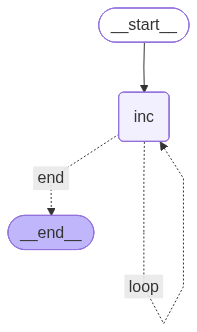

In [16]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())